In [158]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [159]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

In [160]:
test_results={}

rmse=tf.keras.metrics.RootMeanSquaredError()

data=pd.read_csv('/train.csv')

In [161]:
data

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20
4,fffe31003900340031003600,2008-07-24,Female,Service,No,3.0,7.0,6.9,0.52
...,...,...,...,...,...,...,...,...,...
22745,fffe31003500370039003100,2008-12-30,Female,Service,No,1.0,3.0,NaN,0.41
22746,fffe33003000350031003800,2008-01-19,Female,Product,Yes,3.0,6.0,6.7,0.59
22747,fffe390032003000,2008-11-05,Male,Service,Yes,3.0,7.0,NaN,0.72
22748,fffe33003300320036003900,2008-01-10,Female,Service,No,2.0,5.0,5.9,0.52


In [162]:
df=data.copy()

In [163]:
#droping employee Id column
df= df.drop("Employee ID", axis=1)

In [164]:
#checking the null values 
df.isna().sum()

Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [165]:
#dropping the rows with null values for Resource Allocation, Mental Fatigue Score and Burn Rate
missing_rows=df.loc[df['Resource Allocation'].isna(), :].index
df= df.drop(missing_rows, axis=0).reset_index(drop=True)

missing_rows=df.loc[df['Burn Rate'].isna(), :].index
df= df.drop(missing_rows, axis=0).reset_index(drop=True)

missing_rows=df.loc[df['Mental Fatigue Score'].isna(), :].index
df= df.drop(missing_rows, axis=0).reset_index(drop=True)



In [166]:
df.isna().sum()

Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

In [167]:
df['Date of Joining']=pd.to_datetime(df['Date of Joining'])
df['Day of Joining']= df['Date of Joining'].apply(lambda x : x.day)
df['Month of Joining']= df['Date of Joining'].apply(lambda x : x.month)
df['Year of Joining']= df['Date of Joining'].apply(lambda x : x.year)

In [168]:
{column : len(df[column].unique()) for column in df.columns }

{'Burn Rate': 101,
 'Company Type': 2,
 'Date of Joining': 366,
 'Day of Joining': 31,
 'Designation': 6,
 'Gender': 2,
 'Mental Fatigue Score': 101,
 'Month of Joining': 12,
 'Resource Allocation': 10,
 'WFH Setup Available': 2,
 'Year of Joining': 1}

In [169]:
len(df['Year of Joining'].unique())

1

In [170]:
df= df.drop('Year of Joining', axis=1)
df= df.drop('Date of Joining', axis=1)

In [171]:
# Binary Encoding 

df['Gender']= df['Gender'].replace({'Female':0, 'Male': 1})
df['Company Type']= df['Company Type'].replace({'Product':0, 'Service': 1})
df['WFH Setup Available']= df['WFH Setup Available'].replace({'No':0, 'Yes': 1})

In [172]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.04])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Burn Rate')
  plt.legend()
  plt.grid(True)

In [173]:
def plot_mae(history):
  plt.plot(history.history['mae'], label='mae')
  plt.plot(history.history['val_mae'], label='val_mae')
  plt.ylim([0, 0.15])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Burn Rate')
  plt.legend()
  plt.grid(True)

In [174]:
df

,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Day of Joining,Month of Joining
0,0,1,0,2.0,3.0,3.8,0.16,30,9
1,1,1,1,1.0,2.0,5.0,0.36,30,11
2,1,1,1,1.0,1.0,2.6,0.20,3,11
3,0,1,0,3.0,7.0,6.9,0.52,24,7
4,1,0,1,2.0,4.0,3.6,0.29,26,11
...,...,...,...,...,...,...,...,...,...
18585,0,0,1,1.0,3.0,6.0,0.48,15,12
18586,1,0,0,3.0,7.0,6.2,0.54,27,5
18587,0,0,1,3.0,6.0,6.7,0.59,19,1
18588,0,1,0,2.0,5.0,5.9,0.52,10,1


In [175]:
# Split the data into x and y

y= df['Burn Rate']
x= df.drop('Burn Rate', axis=1)


#Train Test Split
x_train, x_test, y_train, y_test= train_test_split(x,y,train_size=0.8,random_state=1)

In [176]:
scaler=StandardScaler()
scaler.fit(x_train)
x_train=pd.DataFrame(scaler.transform(x_train), index= x_train.index, columns=x_train.columns)
x_test=pd.DataFrame(scaler.transform(x_test), index= x_test.index, columns=x_test.columns)

In [177]:
def add_test_results(m,mae_train,mse_train,rmse_train,MAE,MSE,RMSE):
  test_results[m]={'training_errors':[mae_train,mse_train,rmse_train], 'test_errors':[MAE,MSE,RMSE]}


Model 1 Training


In [178]:
model1=keras.Sequential([
layers.Dense(10, activation=tf.nn.relu, input_shape=[len(x_train.keys())]),
layers.Dense(10, activation=tf.nn.relu),
layers.Dense(10, activation=tf.nn.relu),
layers.Dense(10,activation=tf.nn.relu),
layers.Dense(10,activation=tf.nn.relu),
layers.Dense(1)])

model1.compile(keras.optimizers.Adagrad(lr=0.01), loss='mean_squared_error', metrics=['mae','mse',rmse])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [179]:
model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 10)                90        
                                                                 
 dense_69 (Dense)            (None, 10)                110       
                                                                 
 dense_70 (Dense)            (None, 10)                110       
                                                                 
 dense_71 (Dense)            (None, 10)                110       
                                                                 
 dense_72 (Dense)            (None, 10)                110       
                                                                 
 dense_73 (Dense)            (None, 1)                 11        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable

In [180]:
history=model1.fit(x_train, y_train, epochs=30, validation_split=0.2,verbose=1, batch_size=100)

Epoch 1/30
119/119 [==============================] - 1s 4ms/step - loss: 0.0339 - mae: 0.1392 - mse: 0.0339 - root_mean_squared_error: 0.1840 - val_loss: 0.0168 - val_mae: 0.1041 - val_mse: 0.0168 - val_root_mean_squared_error: 0.1295
Epoch 2/30
119/119 [==============================] - 0s 2ms/step - loss: 0.0153 - mae: 0.0988 - mse: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 0.0135 - val_mae: 0.0924 - val_mse: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 3/30
119/119 [==============================] - 0s 2ms/step - loss: 0.0130 - mae: 0.0907 - mse: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0120 - val_mae: 0.0871 - val_mse: 0.0120 - val_root_mean_squared_error: 0.1096
Epoch 4/30
119/119 [==============================] - 0s 2ms/step - loss: 0.0118 - mae: 0.0862 - mse: 0.0118 - root_mean_squared_error: 0.1087 - val_loss: 0.0111 - val_mae: 0.0837 - val_mse: 0.0111 - val_root_mean_squared_error: 0.1052
Epoch 5/30
119/119 [==============================] - 0s

In [ ]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist

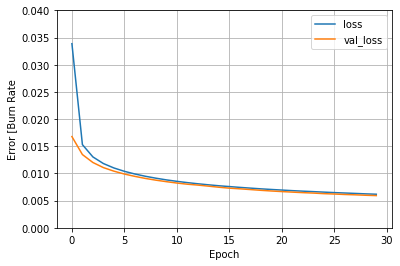

In [182]:
plot_loss(history)


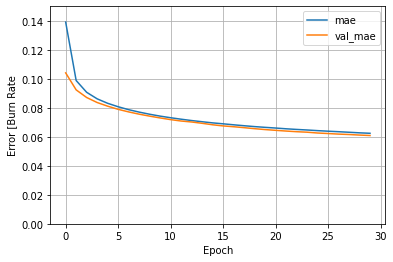

In [183]:
plot_mae(history)

In [184]:
y_pred_train=model1.predict(x_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
mse_train=mean_squared_error(y_train,y_pred_train)
rmse_train=sqrt(mean_squared_error(y_train,y_pred_train))

y_pred=model1.predict(x_test)
MAE= mean_absolute_error(y_test, y_pred)
MSE=mean_squared_error(y_test,y_pred)
RMSE= sqrt(mean_squared_error(y_test,y_pred))

print("Mean Absolute Error for Training Set :",mae_train )
print("Mean square Error for Training Set:",mse_train )
print("Root Mean square Error for Training Set:", rmse_train)

print("Mean Absolute Error for Test Set :", MAE)
print("Mean square Error for Test Set:", MSE)
print("Root Mean square Error for Test Set:", RMSE)

Mean Absolute Error for Training Set : 0.06195939986094344
Mean square Error for Training Set: 0.006087498421570673
Root Mean square Error for Training Set: 0.07802242255640793
Mean Absolute Error for Test Set : 0.06259474749892806
Mean square Error for Test Set: 0.006117453824615613
Root Mean square Error for Test Set: 0.07821415360799867


In [185]:
add_test_results('m1',mae_train,mse_train,rmse_train,MAE,MSE,RMSE)

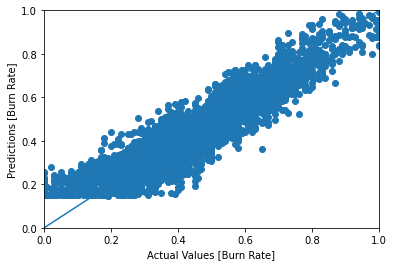

In [186]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values [Burn Rate]')
plt.ylabel('Predictions [Burn Rate]')
lims = [0, 1]
plt.xlim(0,1)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Model 2 Training

In [187]:
model2=keras.Sequential([
layers.Dense(12, activation=tf.nn.relu, input_shape=[len(x_train.keys())]),
layers.Dense(24, activation=tf.nn.relu),
layers.Dense(10, activation=tf.nn.relu),
layers.Dense(10,activation=tf.nn.relu),
layers.Dense(10,activation=tf.nn.relu),
layers.Dense(1)])

model2.compile(keras.optimizers.Adagrad(lr=0.01), loss='mean_squared_error', metrics=['mae','mse',rmse])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [188]:
model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 12)                108       
                                                                 
 dense_75 (Dense)            (None, 24)                312       
                                                                 
 dense_76 (Dense)            (None, 10)                250       
                                                                 
 dense_77 (Dense)            (None, 10)                110       
                                                                 
 dense_78 (Dense)            (None, 10)                110       
                                                                 
 dense_79 (Dense)            (None, 1)                 11        
                                                                 
Total params: 901
Trainable params: 901
Non-trainable

In [189]:
history=model2.fit(x_train, y_train, epochs=30, validation_split=0.2,verbose=0, batch_size=100)

In [ ]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist

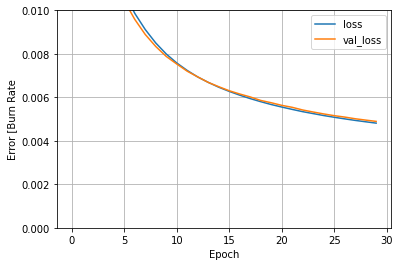

In [191]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

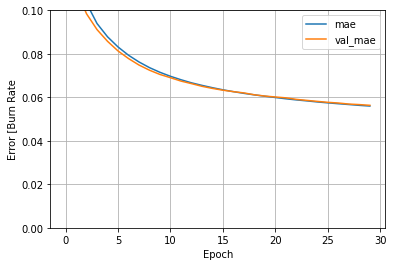

In [192]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

In [193]:
y_pred_train=model2.predict(x_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
mse_train=mean_squared_error(y_train,y_pred_train)
rmse_train=sqrt(mean_squared_error(y_train,y_pred_train))

y_pred=model2.predict(x_test)
MAE= mean_absolute_error(y_test, y_pred)
MSE=mean_squared_error(y_test,y_pred)
RMSE= sqrt(mean_squared_error(y_test,y_pred))

print("Mean Absolute Error for Training Set :",mae_train )
print("Mean square Error for Training Set:",mse_train )
print("Root Mean square Error for Training Set:", rmse_train)

print("Mean Absolute Error for Test Set :", MAE)
print("Mean square Error for Test Set:", MSE)
print("Root Mean square Error for Test Set:", RMSE)

Mean Absolute Error for Training Set : 0.055858974052435804
Mean square Error for Training Set: 0.004797921173614328
Root Mean square Error for Training Set: 0.06926702804086753
Mean Absolute Error for Test Set : 0.05520834153116294
Mean square Error for Test Set: 0.004734098246245043
Root Mean square Error for Test Set: 0.06880478360001609


In [194]:
add_test_results('m2',mae_train,mse_train,rmse_train,MAE,MSE,RMSE)

Model 3 

In [239]:
model3=keras.Sequential([
layers.Dense(8, activation=tf.nn.relu, input_shape=[len(x_train.keys())]),
layers.Dense(16, activation=tf.nn.relu),
layers.Dense(24, activation=tf.nn.relu),
layers.Dense(16,activation=tf.nn.relu),
layers.Dense(10,activation=tf.nn.relu),
layers.Dense(10,activation=tf.nn.relu),
layers.Dense(1)])
model3.compile(keras.optimizers.Adagrad(lr=0.1), loss='mean_squared_error', metrics=['mae','mse',rmse])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


In [196]:
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 8)                 72        
                                                                 
 dense_81 (Dense)            (None, 16)                144       
                                                                 
 dense_82 (Dense)            (None, 24)                408       
                                                                 
 dense_83 (Dense)            (None, 16)                400       
                                                                 
 dense_84 (Dense)            (None, 10)                170       
                                                                 
 dense_85 (Dense)            (None, 10)                110       
                                                                 
 dense_86 (Dense)            (None, 1)               

In [240]:
history=model3.fit(x_train, y_train, epochs=100, validation_split=0.2,verbose=0, batch_size=100)

In [ ]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist

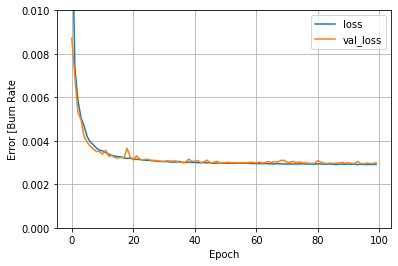

In [241]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

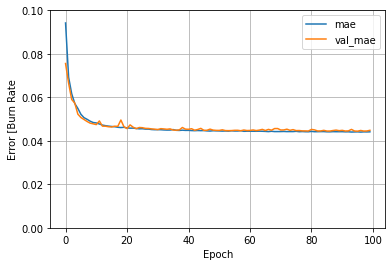

In [243]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

In [242]:

y_pred_train=model3.predict(x_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
mse_train=mean_squared_error(y_train,y_pred_train)
rmse_train=sqrt(mean_squared_error(y_train,y_pred_train))

y_pred=model3.predict(x_test)
MAE= mean_absolute_error(y_test, y_pred)
MSE=mean_squared_error(y_test,y_pred)
RMSE= sqrt(mean_squared_error(y_test,y_pred))


print("Mean Absolute Error for Training Set :",mae_train )
print("Mean square Error for Training Set:",mse_train )
print("Root Mean square Error for Training Set:", rmse_train)

print("Mean Absolute Error for Test Set :", MAE)
print("Mean square Error for Test Set:", MSE)
print("Root Mean square Error for Test Set:", RMSE)

Mean Absolute Error for Training Set : 0.04418465399614677
Mean square Error for Training Set: 0.002913717805388181
Root Mean square Error for Training Set: 0.05397886443218476
Mean Absolute Error for Test Set : 0.045020056301512464
Mean square Error for Test Set: 0.003017408798571723
Root Mean square Error for Test Set: 0.0549309457279931


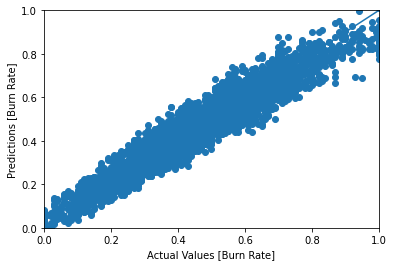

In [237]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values [Burn Rate]')
plt.ylabel('Predictions [Burn Rate]')
lims = [0, 1]
plt.xlim(0,1)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [238]:
add_test_results('m3',mae_train,mse_train,rmse_train,MAE,MSE,RMSE)

model 4

In [244]:
model4=keras.Sequential([
layers.Dense(16, activation=tf.nn.relu, input_shape=[len(x_train.keys())]),
layers.Dense(12, activation=tf.nn.relu),
layers.Dense(8, activation=tf.nn.relu),
layers.Dense(4,activation=tf.nn.relu),
layers.Dense(1)])
model4.compile(keras.optimizers.Adagrad(lr=0.1), loss='mean_squared_error', metrics=['mae','mse',rmse])
history=model4.fit(x_train, y_train, epochs=50, validation_split=0.2,verbose=1, batch_size=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0084 - mae: 0.0672 - mse: 0.0084 - root_mean_squared_error: 0.0857 - val_loss: 0.0042 - val_mae: 0.0522 - val_mse: 0.0042 - val_root_mean_squared_error: 0.0648
Epoch 2/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0039 - mae: 0.0508 - mse: 0.0039 - root_mean_squared_error: 0.0627 - val_loss: 0.0036 - val_mae: 0.0489 - val_mse: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 3/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0036 - mae: 0.0486 - mse: 0.0036 - root_mean_squared_error: 0.0596 - val_loss: 0.0034 - val_mae: 0.0473 - val_mse: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 4/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0033 - mae: 0.0471 - mse: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0032 - val_mae: 0.0461 - val_mse: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 5/50
372/372 [==============================] - 1s

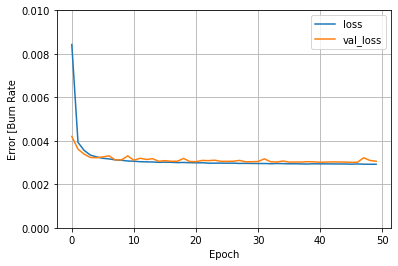

In [245]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

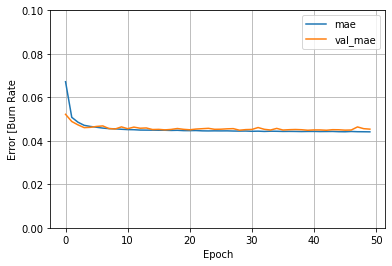

In [246]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

In [207]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist

,loss,mae,mse,root_mean_squared_error,val_loss,val_mae,val_mse,val_root_mean_squared_error,epoch
0,0.007971,0.067467,0.007971,0.083591,0.004155,0.052065,0.004155,0.064456,0
1,0.003872,0.050343,0.003872,0.062225,0.003608,0.049189,0.003608,0.060065,1
2,0.003483,0.047878,0.003483,0.059019,0.003971,0.051085,0.003971,0.063016,2
3,0.003310,0.046748,0.003310,0.057530,0.003379,0.047520,0.003379,0.058127,3
4,0.003258,0.046401,0.003258,0.057075,0.003179,0.045947,0.003179,0.056382,4
5,0.003222,0.046119,0.003222,0.056764,0.003467,0.047947,0.003467,0.058878,5
6,0.003159,0.045728,0.003159,0.056202,0.003175,0.045881,0.003175,0.056348,6
7,0.003129,0.045441,0.003129,0.055940,0.003118,0.045700,0.003118,0.055835,7
8,0.003104,0.045405,0.003104,0.055717,0.003191,0.046250,0.003191,0.056489,8
9,0.003096,0.045349,0.003096,0.055637,0.003054,0.045108,0.003054,0.055259,9


In [247]:
y_pred_train=model4.predict(x_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
mse_train=mean_squared_error(y_train,y_pred_train)
rmse_train=sqrt(mean_squared_error(y_train,y_pred_train))

y_pred=model4.predict(x_test)
MAE= mean_absolute_error(y_test, y_pred)
MSE=mean_squared_error(y_test,y_pred)
RMSE= sqrt(mean_squared_error(y_test,y_pred))


print("Mean Absolute Error for Training Set :",mae_train )
print("Mean square Error for Training Set:",mse_train )
print("Root Mean square Error for Training Set:", rmse_train)

print("Mean Absolute Error for Test Set :", MAE)
print("Mean square Error for Test Set:", MSE)
print("Root Mean square Error for Test Set:", RMSE)

Mean Absolute Error for Training Set : 0.044375912823953284
Mean square Error for Training Set: 0.0029342900829840506
Root Mean square Error for Training Set: 0.054169087891379995
Mean Absolute Error for Test Set : 0.04508486062392488
Mean square Error for Test Set: 0.003021091623637819
Root Mean square Error for Test Set: 0.05496445782173985


In [248]:
add_test_results('m4',mae_train,mse_train,rmse_train,MAE,MSE,RMSE)

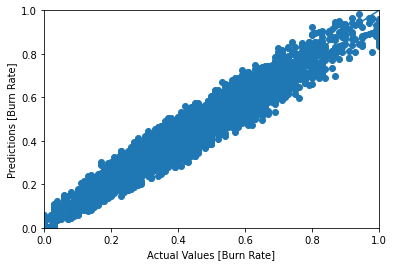

In [210]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values [Burn Rate]')
plt.ylabel('Predictions [Burn Rate]')
lims = [0, 1]
plt.xlim(0,1)
plt.ylim(lims)
_ = plt.plot(lims, lims)

Model 5

In [271]:
rmse=tf.keras.metrics.RootMeanSquaredError()
model5=keras.Sequential([
layers.Dense(12, activation=tf.nn.relu, input_shape=[len(x_train.keys())]),
layers.Dense(10, activation=tf.nn.relu),
layers.Dense(8, activation=tf.nn.relu),
layers.Dense(4,activation=tf.nn.relu),
layers.Dense(1)])
model5.compile(keras.optimizers.Adagrad(lr=0.1), loss='mean_squared_error', metrics=['mae','mse', rmse])
history=model5.fit(x_train, y_train, epochs=50, validation_split=0.2,verbose=1, batch_size=32)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/50
372/372 [==============================] - 1s 3ms/step - loss: 0.0123 - mae: 0.0784 - mse: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0042 - val_mae: 0.0522 - val_mse: 0.0042 - val_root_mean_squared_error: 0.0649
Epoch 2/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0037 - mae: 0.0491 - mse: 0.0037 - root_mean_squared_error: 0.0610 - val_loss: 0.0034 - val_mae: 0.0465 - val_mse: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 3/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0034 - mae: 0.0469 - mse: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0032 - val_mae: 0.0453 - val_mse: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 4/50
372/372 [==============================] - 1s 2ms/step - loss: 0.0032 - mae: 0.0461 - mse: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.0031 - val_mae: 0.0451 - val_mse: 0.0031 - val_root_mean_squared_error: 0.0557
Epoch 5/50
372/372 [==============================] - 1s

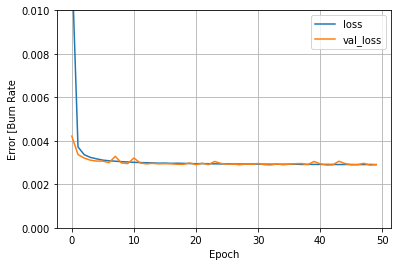

In [272]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

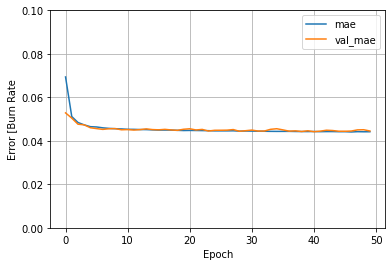

In [269]:
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.ylim([0, 0.1])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

In [270]:
y_pred_train=model5.predict(x_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
mse_train=mean_squared_error(y_train,y_pred_train)
rmse_train=sqrt(mean_squared_error(y_train,y_pred_train))

y_pred=model5.predict(x_test)
MAE= mean_absolute_error(y_test, y_pred)
MSE=mean_squared_error(y_test,y_pred)
RMSE= sqrt(mean_squared_error(y_test,y_pred))


print("Mean Absolute Error for Training Set :",mae_train )
print("Mean square Error for Training Set:",mse_train )
print("Root Mean square Error for Training Set:", rmse_train)

print("Mean Absolute Error for Test Set :", MAE)
print("Mean square Error for Test Set:", MSE)
print("Root Mean square Error for Test Set:", RMSE)

Mean Absolute Error for Training Set : 0.04405557235285055
Mean square Error for Training Set: 0.0028970993098667228
Root Mean square Error for Training Set: 0.05382470910155226
Mean Absolute Error for Test Set : 0.04509774427297873
Mean square Error for Test Set: 0.002997805826786506
Root Mean square Error for Test Set: 0.05475222211733973


In [215]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist

,loss,mae,mse,root_mean_squared_error,val_loss,val_mae,val_mse,val_root_mean_squared_error,epoch
0,0.011380,0.079128,0.011380,0.106678,0.006342,0.063623,0.006342,0.079635,0
1,0.005046,0.057147,0.005046,0.071035,0.004235,0.052577,0.004235,0.065076,1
2,0.003983,0.051541,0.003983,0.063111,0.003755,0.049775,0.003755,0.061274,2
3,0.003595,0.049091,0.003595,0.059960,0.004132,0.052985,0.004132,0.064280,3
4,0.003452,0.048113,0.003452,0.058751,0.003437,0.048514,0.003437,0.058626,4
5,0.003342,0.047252,0.003342,0.057812,0.003291,0.047358,0.003291,0.057369,5
6,0.003286,0.046806,0.003286,0.057324,0.003367,0.048037,0.003367,0.058025,6
7,0.003214,0.046244,0.003214,0.056694,0.003206,0.046820,0.003206,0.056622,7
8,0.003200,0.046245,0.003200,0.056564,0.003182,0.046500,0.003182,0.056413,8
9,0.003149,0.045876,0.003149,0.056114,0.003237,0.047123,0.003237,0.056894,9


In [273]:
add_test_results('m5',mae_train,mse_train,rmse_train,MAE,MSE,RMSE)

In [217]:
test_results.pop('m5')

{'test_errors': [0.04533456058918252,
  0.0030448589333656683,
  0.055180240425044075],
 'training_errors': [0.04451353627899556,
  0.00294574640880109,
  0.054274730849642086]}

In [218]:
test_results

{'m1': {'test_errors': [0.06259474749892806,
   0.006117453824615613,
   0.07821415360799867],
  'training_errors': [0.06195939986094344,
   0.006087498421570673,
   0.07802242255640793]},
 'm2': {'test_errors': [0.05520834153116294,
   0.004734098246245043,
   0.06880478360001609],
  'training_errors': [0.055858974052435804,
   0.004797921173614328,
   0.06926702804086753]},
 'm3': {'test_errors': [0.04561844133117175,
   0.0030830920674518583,
   0.05552559830791433],
  'training_errors': [0.044806352527576664,
   0.0029919417220182786,
   0.05469864460860323]},
 'm4': {'test_errors': [0.04521364505534501,
   0.0030360161901735903,
   0.05510005617214551],
  'training_errors': [0.04411073401285763,
   0.002910644434175498,
   0.05395038863785411]}}

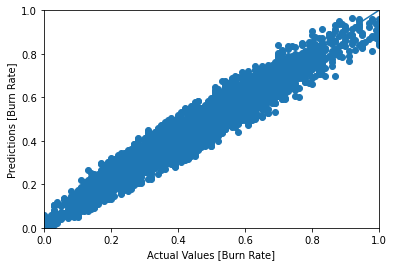

In [219]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values [Burn Rate]')
plt.ylabel('Predictions [Burn Rate]')
lims = [0, 1]
plt.xlim(0,1)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [220]:
model6=keras.Sequential([
layers.Dense(12, activation=tf.nn.relu, input_shape=[len(x_train.keys())]),
layers.Dense(10, activation=tf.nn.relu),
layers.Dense(8, activation=tf.nn.relu),
layers.Dense(4,activation=tf.nn.relu),
layers.Dense(1)])
model6.compile(keras.optimizers.Adagrad(lr=0.1), loss='mean_squared_error', metrics=['mae','mse',rmse])
history=model6.fit(x_train, y_train, epochs=300, validation_split=0.2,verbose=1, batch_size=300)



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


Epoch 1/300
40/40 [==============================] - 1s 6ms/step - loss: 0.0303 - mae: 0.1237 - mse: 0.0303 - root_mean_squared_error: 0.1575 - val_loss: 0.0149 - val_mae: 0.0984 - val_mse: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 2/300
40/40 [==============================] - 0s 3ms/step - loss: 0.0131 - mae: 0.0914 - mse: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0118 - val_mae: 0.0877 - val_mse: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 3/300
40/40 [==============================] - 0s 3ms/step - loss: 0.0106 - mae: 0.0823 - mse: 0.0106 - root_mean_squared_error: 0.1027 - val_loss: 0.0098 - val_mae: 0.0800 - val_mse: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 4/300
40/40 [==============================] - 0s 3ms/step - loss: 0.0088 - mae: 0.0756 - mse: 0.0088 - root_mean_squared_error: 0.0940 - val_loss: 0.0084 - val_mae: 0.0746 - val_mse: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 5/300
40/40 [==============================] - 0s 2ms/

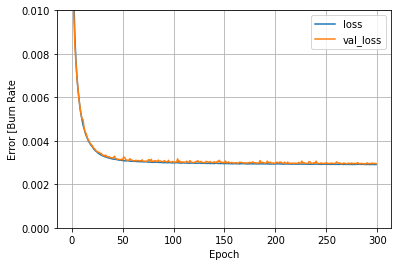

In [221]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.01])
plt.xlabel('Epoch')
plt.ylabel('Error [Burn Rate')
plt.legend()
plt.grid(True)

In [222]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
hist

,loss,mae,mse,root_mean_squared_error,val_loss,val_mae,val_mse,val_root_mean_squared_error,epoch
0,0.030272,0.123653,0.030272,0.157536,0.014869,0.098394,0.014869,0.121937,0
1,0.013125,0.091424,0.013125,0.114565,0.011822,0.087696,0.011822,0.108730,1
2,0.010556,0.082274,0.010556,0.102742,0.009777,0.079973,0.009777,0.098878,2
3,0.008842,0.075643,0.008842,0.094035,0.008419,0.074600,0.008419,0.091757,3
4,0.007757,0.070979,0.007757,0.088076,0.007631,0.071249,0.007631,0.087357,4
...,...,...,...,...,...,...,...,...,...
295,0.002918,0.044133,0.002918,0.054018,0.002980,0.044367,0.002980,0.054593,295
296,0.002911,0.044058,0.002911,0.053950,0.002952,0.044407,0.002952,0.054333,296
297,0.002907,0.044044,0.002907,0.053919,0.002954,0.044409,0.002954,0.054350,297
298,0.002912,0.044067,0.002912,0.053964,0.002960,0.044471,0.002960,0.054403,298


In [223]:
y_pred_train=model6.predict(x_train)
mae_train=mean_absolute_error(y_train, y_pred_train)
mse_train=mean_squared_error(y_train,y_pred_train)
rmse_train=sqrt(mean_squared_error(y_train,y_pred_train))

y_pred=model6.predict(x_test)
MAE= mean_absolute_error(y_test, y_pred)
MSE=mean_squared_error(y_test,y_pred)
RMSE= sqrt(mean_squared_error(y_test,y_pred))


print("Mean Absolute Error for Training Set :",mae_train )
print("Mean square Error for Training Set:",mse_train )
print("Root Mean square Error for Training Set:", rmse_train)

print("Mean Absolute Error for Test Set :", MAE)
print("Mean square Error for Test Set:", MSE)
print("Root Mean square Error for Test Set:", RMSE)

Mean Absolute Error for Training Set : 0.04404144313531082
Mean square Error for Training Set: 0.002910554161853629
Root Mean square Error for Training Set: 0.05394955200790484
Mean Absolute Error for Test Set : 0.04486786725806125
Mean square Error for Test Set: 0.003004434661637083
Root Mean square Error for Test Set: 0.054812723537852805


In [224]:
add_test_results('m6',mae_train,mse_train,rmse_train,MAE,MSE,RMSE)

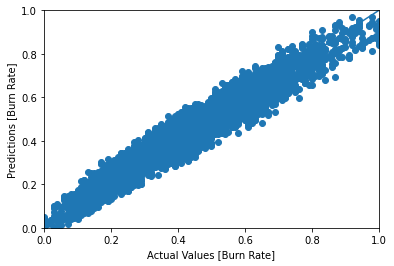

In [225]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values [Burn Rate]')
plt.ylabel('Predictions [Burn Rate]')
lims = [0, 1]
plt.xlim(0,1)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [142]:
models=[model1,model2,model3,model4,model5,model6]

for model in models:
  model.evaluate(x_test,y_test)

117/117 [==============================] - 0s 1ms/step - loss: 0.0030 - mae: 0.0450 - mse: 0.0030 - root_mean_squared_error: 0.0550


In [403]:
ms = np.array([test_results['m1']['test_errors'][1], test_results['m2']['test_errors'][1],test_results['m3']['test_errors'][1],test_results['m4']['test_errors'][1], test_results['m5']['test_errors'][1], test_results['m6']['test_errors'][1]])
a = np.array([test_results['m1']['test_errors'][0], test_results['m2']['test_errors'][0],test_results['m3']['test_errors'][0],test_results['m4']['test_errors'][0], test_results['m5']['test_errors'][0], test_results['m6']['test_errors'][0]])
rm = np.array([test_results['m1']['test_errors'][2], test_results['m2']['test_errors'][2],test_results['m3']['test_errors'][2],test_results['m4']['test_errors'][2], test_results['m5']['test_errors'][2], test_results['m6']['test_errors'][2]])


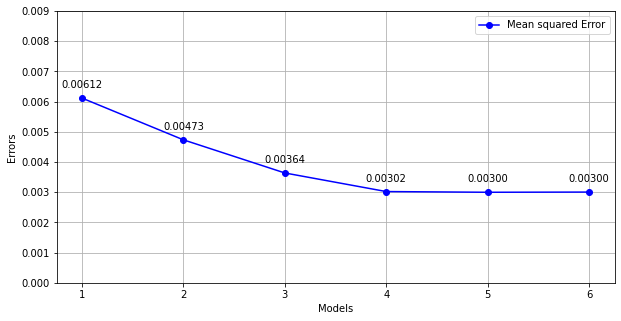

In [406]:
x1=[1,2,3,4,5,6]
y1=ms
plt.figure(figsize=(10, 5))
plt.ylim([0, 0.009])
plt.plot(x1,y1,'bo-',label='Mean squared Error')
plt.xlabel('Models')
plt.ylabel('Errors')
plt.legend()
plt.grid(True)
for x,y in zip(x1,y1):

    label = "{:.5f}".format(y)

    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

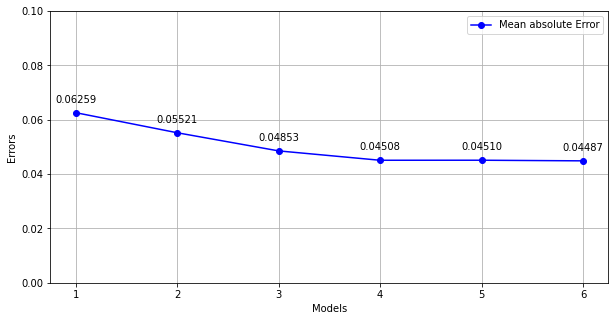

In [404]:
x1=[1,2,3,4,5,6]
y1=a
plt.figure(figsize=(10, 5))
plt.ylim([0, 0.1])
plt.plot(x1,y1,'bo-',label='Mean absolute Error')
plt.xlabel('Models')
plt.ylabel('Errors')
plt.legend()
plt.grid(True)
for x,y in zip(x1,y1):

    label = "{:.5f}".format(y)

    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

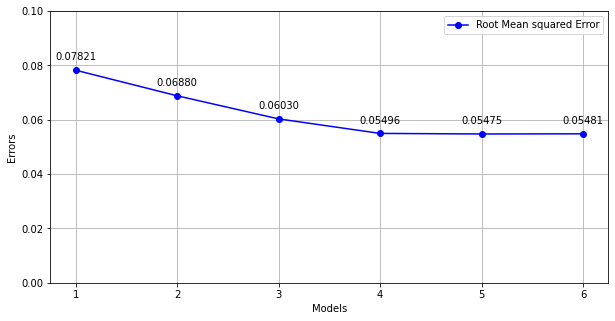

In [405]:
x1=[1,2,3,4,5,6]
y1=rm

plt.figure(figsize=(10, 5))
plt.plot(x1,y1,'bo-',label='Root Mean squared Error')
plt.xlabel('Models')
plt.ylabel('Errors')
plt.ylim([0, 0.1])
plt.legend()
plt.grid(True)
for x,y in zip(x1,y1):

    label = "{:.5f}".format(y)

    plt.annotate(label,
                 (x,y), 
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

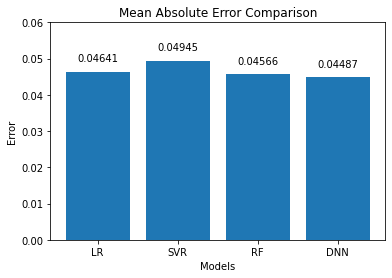

In [402]:

x2=['LR','SVR','RF','DNN']
y2=[0.04640970525020264,0.04944618805577363,0.04565849397397473,test_results['m6']['test_errors'][0]]
plt.bar(x2,y2)
plt.ylim([0, 0.06])
plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Mean Absolute Error Comparison')
# zip joins x and y coordinates in pairs
for x,y in zip(x2,y2):

    label = "{:.5f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

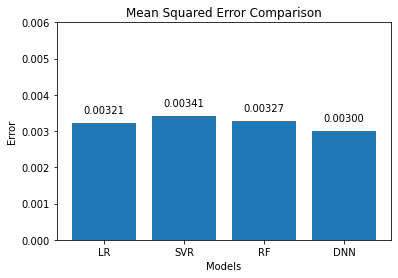

In [401]:
x2=['LR','SVR','RF','DNN']
y2=[0.003212345462220203,0.0034056033686410726,0.0032739242689967976,test_results['m6']['test_errors'][1]]
plt.bar(x2,y2)
plt.ylim([0, 0.006])
plt.title('Mean Squared Error Comparison')
plt.xlabel('Models')
plt.ylabel('Error')
# zip joins x and y coordinates in pairs
for x,y in zip(x2,y2):

    label = "{:.5f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

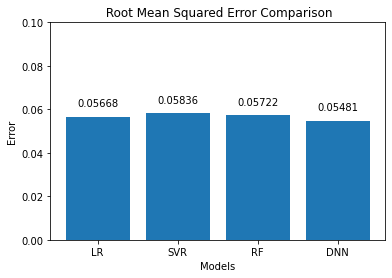

In [400]:
x2=['LR','SVR','RF','DNN']
y2=[0.05667755695352617,0.05835754765787432,0.05721821623396519,test_results['m6']['test_errors'][2]]
plt.bar(x2,y2)
plt.ylim([0, 0.1])
plt.title(' Root Mean Squared Error Comparison')
plt.xlabel('Models')
plt.ylabel('Error')
# zip joins x and y coordinates in pairs
for x,y in zip(x2,y2):

    label = "{:.5f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()
